# Tutorial 7a - Generative Adversarial Networks

Thus far, we have discussed several **generative** models. A generative
model learns the *structure* of a set of input data. In doing so, the model
learns to *generate* new data that it has never seen before in the training
data. The generative models we discussed were:

- an autoencoder
- an RNN used to generate text

A Generative Adversarial Network (GAN) is yet another example of a generative
model. To motivate the GAN, let's first discuss the drawbacks of an autoencoder.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


## Autoencoder Review

Here is the code that we wrote back in the autoencoder lecture.
The autoencoder model consists of an **encoder** that maps 
images to a vector embedding, and a **decoder** that reconstructs
images from an embedding.

In [0]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [0]:
def loss_function(recon, img):
  return torch.sum(torch.abs(recon - img))

In [21]:
a = [[1.0, 2.0], [3.0, 3.0]]
b = [[1.0, 4.0], [3.0, 4.0]]
print(torch.sum(torch.tensor(a) - torch.tensor(b)))

tensor(-3.)


We trained an autoencoder model on the reconstruction loss: the difference in
pixel intensities between a real image and its reconstruction.

In [29]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, label = data
            recon = model(img)
            #loss = criterion(recon, img)
            loss = loss_function(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
        torch.save(model.state_dict(), "autoencoder%d.pt" % epoch)
    return outputs

model = Autoencoder()
outputs = train(model, num_epochs=30)

Epoch:1, Loss:867.6301
Epoch:2, Loss:580.9391
Epoch:3, Loss:488.3551
Epoch:4, Loss:403.2933
Epoch:5, Loss:388.6004
Epoch:6, Loss:376.1824
Epoch:7, Loss:359.2986
Epoch:8, Loss:352.4961
Epoch:9, Loss:380.8210
Epoch:10, Loss:355.5468
Epoch:11, Loss:355.2255
Epoch:12, Loss:346.9341
Epoch:13, Loss:356.1450
Epoch:14, Loss:358.5950
Epoch:15, Loss:362.4031
Epoch:16, Loss:367.4558
Epoch:17, Loss:355.8626
Epoch:18, Loss:343.0672
Epoch:19, Loss:323.9194
Epoch:20, Loss:320.5566
Epoch:21, Loss:293.4111
Epoch:22, Loss:343.7309
Epoch:23, Loss:322.0420
Epoch:24, Loss:336.4427
Epoch:25, Loss:329.8126
Epoch:26, Loss:297.6825
Epoch:27, Loss:341.1608
Epoch:28, Loss:344.4953
Epoch:29, Loss:330.3433
Epoch:30, Loss:325.8265


In [30]:
# Choose a model to load -- after 2 epochs of training
ckpt = torch.load("autoencoder1.pt")
model.load_state_dict(ckpt)

<All keys matched successfully>

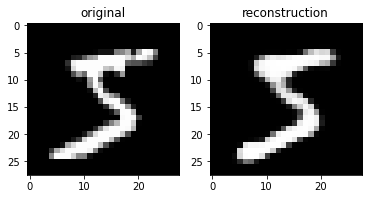

In [31]:
original = mnist_data[0][0].unsqueeze(0)
emb = model.encoder(original)
recon_img = model.decoder(emb).detach().numpy()[0,0,:,:]

# plot the original image
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(original[0][0], cmap='gray')

# plot the reconstructed
plt.subplot(1,2,2)
plt.title("reconstruction")
plt.imshow(recon_img, cmap='gray')

Let's take a look at one MNIST image from training,
and its autoencoder reconstruction:

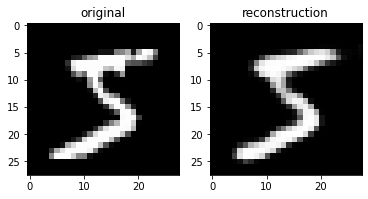

In [18]:
original = mnist_data[0][0].unsqueeze(0)
emb = model.encoder(original)
recon_img = model.decoder(emb).detach().numpy()[0,0,:,:]

# plot the original image
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(original[0][0], cmap='gray')

# plot the reconstructed
plt.subplot(1,2,2)
plt.title("reconstruction")
plt.imshow(recon_img, cmap='gray')

The reconstruction is reasonable, but notice that the reconstruction
is blurrier than
the original image. If we perturb the embedding to generate a new image, we
still should see this blurriness:

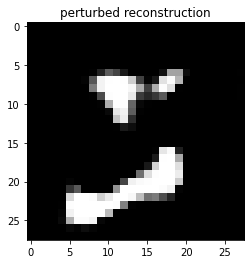

In [32]:
# Run this a few times
x = emb + 10 * torch.randn(1, 64, 1, 1) # add a random perturbation

# reconstruct image and plot
img = model.decoder(x)[0,0,:,:]
img = img.detach().numpy()
plt.title("perturbed reconstruction")
plt.imshow(img, cmap='gray')

The reason autoencoders tend to generate blurry images is because of the
loss function that it uses.
The use of `MSELoss` (mean square error loss) has an *averaging* effect.
If the model learns that two possible values for a pixel is 0 and 1, then it
will learn to predict a value of 0.5 for that pixel to minimize the mean square error.
However, none of our training data might have a pixel intensity of 0.5 at that pixel!
A human would easily tell the difference between a generated image and a real image.

But what would be a more appropriate loss function than the MSELoss? People have
tried to come up with better loss functions, but it is difficult to construct
a general enough loss function that is appropriate for all kinds of generation
tasks. What we really want to do is **learn** a loss function!

The main idea is that generates images that fail to fool a human should also
fail to fool a neural network trained to differentiate real vs fake images.
We can use the prediction of this **discriminator** neural network to guide
the training of our **generator** network.

## Generative Adversarial Network

A generative adversarial network (GAN) model consists of two models:

- A **Generator** network $G$ that takes in a latent embedding (usually random noise)
  and generates an image like those that exists in the training data
- A **Discriminator** network $D$ that tries to distinguish between real images
  from the training data, and fake images produced by the generator

In essense, we have two neural networks that are adversaries: the generator
wants to fool the discriminator, and the discriminator wants to avoid being
fooled. The setup is known as a **min-max game**.

Let's set up a sample generator and a discriminator to start:

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        #self.bat = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0)
        
    def forward(self, x):
        x = x.view(-1, 28*28) # flatten image
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = self.fc4(x)
        return out

class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 28*28)
        self.dropout = nn.Dropout(0)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = F.tanh(self.fc4(x))
        return out

D = Discriminator()
G = Generator()

For now, both the Discriminator and Generator are fully-connected networks.
One difference between these models and the previous models we've built is
that we are using a `nn.LeakyReLU` activation.

Leaky ReLU is a variation
of the ReLU activation that lets some information through, even when
its input is less than 0. The layer `nn.LeakyReLU(0.2)` 
performs the computation: `x if x > 0 else 0.2 * x`.

But what loss function should we optimize? Consider the following quantity:

`P(D correctly identifies real image) + P(D correctly identifies image generated by G)`

A good **discriminator** would want to *maximize* the above quanity by altering
its parameters.

Likewise, a good **generator** would want to *minimize* the above quanity. Actually,
the only term that the generator controls is `P(D correctly identifies image generated by G)`
So, the best thing for the generator to do is alter its parameters to generate images
that can fool D.

Since we are looking at class probabilities, we will use binary cross entropy loss.

Here is a training loop to train a GAN.
For every minibatch of data, we train the discriminator for one iteration,
and then we train the generator for one iteration.

For the discriminator, we use the label `1` to represent a **fake** image, and `0` to represent
a real image.

Let's try training the network.

In [0]:
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data

def train(G, D, lr=0.002, batch_size=64, num_epochs=20):

    rand_size = 100;

    # optimizers for generator and discriminator
    d_optimizer = optim.Adam(D.parameters(), lr)
    g_optimizer = optim.Adam(G.parameters(), lr)
 
    # define loss function
    criterion = nn.BCEWithLogitsLoss()

    # get the training datasets
    train_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

    # prepare data loader
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # fixed data for testing
    sample_size=16
    test_noise = np.random.uniform(-1, 1, size=(sample_size, rand_size))
    test_noise = torch.from_numpy(test_noise).float()

    for epoch in range(num_epochs):
        D.train()
        G.train()
        
        for batch_i, (real_images, _) in enumerate(train_loader):
                    
            batch_size = real_images.size(0)
            
            # rescale images to range -1 to 1
            real_images = real_images*2 - 1
            
            # === Train the Discriminator ===
            
            d_optimizer.zero_grad()

            # discriminator losses on real images 
            D_real = D(real_images)
            labels = torch.ones(batch_size)
            d_real_loss = criterion(D_real.squeeze(), labels)
            
            # discriminator losses on fake images
            z = np.random.uniform(-1, 1, size=(batch_size, rand_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)

            D_fake = D(fake_images)
            labels = torch.zeros(batch_size) # fake labels = 0
            d_fake_loss = criterion(D_fake.squeeze(), labels)
            
            # add up losses and update parameters
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            

            # === Train the Generator ===
            g_optimizer.zero_grad()
            
            # generator losses on fake images
            z = np.random.uniform(-1, 1, size=(batch_size, rand_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)
          
            D_fake = D(fake_images)
            labels = torch.ones(batch_size) #flipped labels

            # compute loss and update parameters
            g_loss = criterion(D_fake.squeeze(), labels)
            g_loss.backward()
            g_optimizer.step()

        # print loss
        print('Epoch [%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
              % (epoch + 1, num_epochs, d_loss.item(), g_loss.item()))

        # append discriminator loss and generator loss
        losses.append((d_loss.item(), g_loss.item()))
        
        # plot images
        G.eval()
        D.eval()
        test_images = G(test_noise)

        plt.figure(figsize=(9, 3))
        for k in range(16):
            plt.subplot(2, 8, k+1)
            plt.imshow(test_images[k,:].data.numpy().reshape(28, 28), cmap='Greys')
        plt.show()
    
    return losses

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [1/20], d_loss: 0.0009, g_loss: 7.9703, 


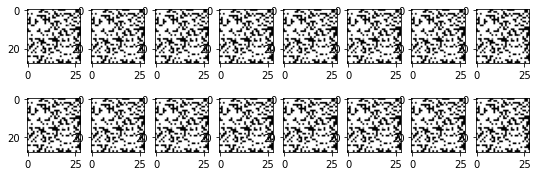

Epoch [2/20], d_loss: 0.0000, g_loss: 11.5008, 


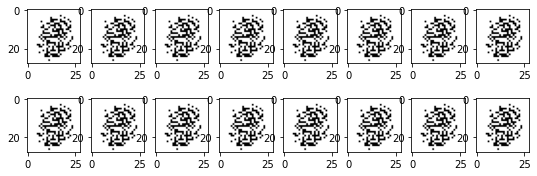

Epoch [3/20], d_loss: 0.0000, g_loss: 12.8181, 


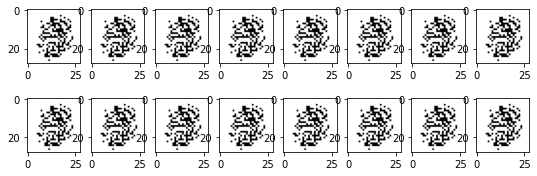

Epoch [4/20], d_loss: 0.0000, g_loss: 13.9090, 


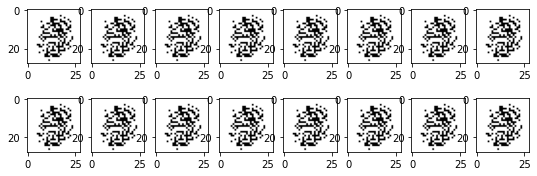

Epoch [5/20], d_loss: 0.0000, g_loss: 14.5437, 


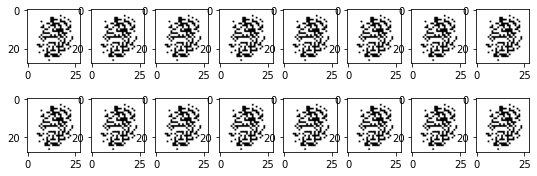

Epoch [6/20], d_loss: 0.0000, g_loss: 15.0723, 


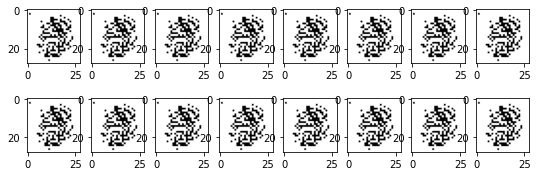

Epoch [7/20], d_loss: 0.0021, g_loss: 9.1914, 


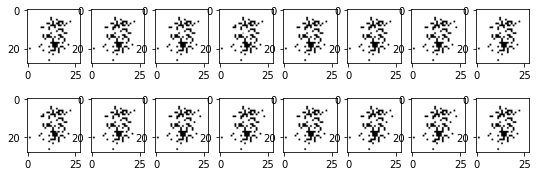

Epoch [8/20], d_loss: 0.0000, g_loss: 12.5023, 


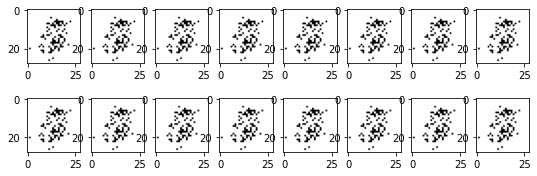

Epoch [9/20], d_loss: 0.0000, g_loss: 13.6085, 


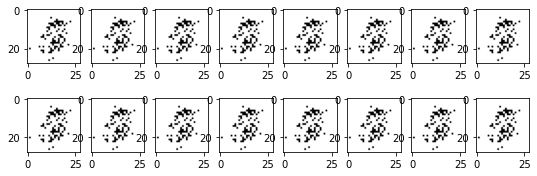

Epoch [10/20], d_loss: 0.0000, g_loss: 14.3273, 


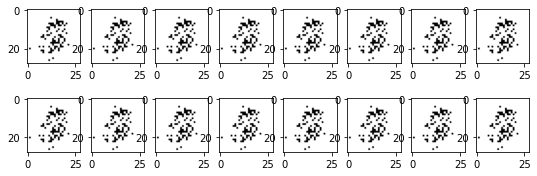

Epoch [11/20], d_loss: 0.0000, g_loss: 15.0658, 


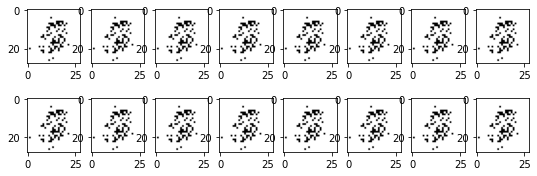

Epoch [12/20], d_loss: 0.0000, g_loss: 15.7045, 


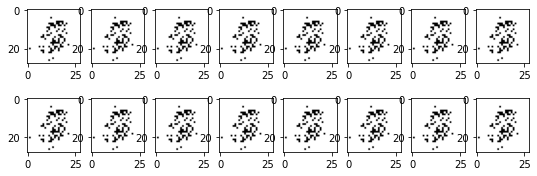

Epoch [13/20], d_loss: 0.0000, g_loss: 16.2904, 


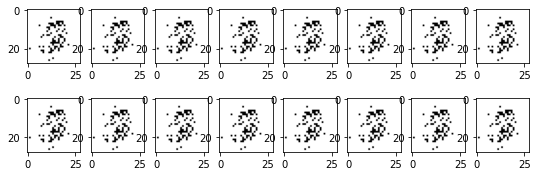

Epoch [14/20], d_loss: 0.0000, g_loss: 16.8925, 


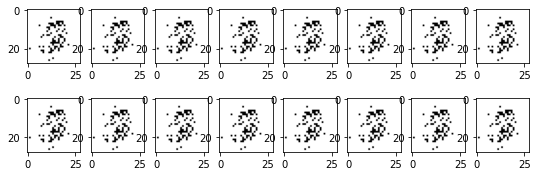

Epoch [15/20], d_loss: 0.0000, g_loss: 17.3899, 


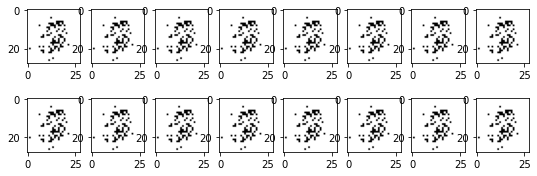

Epoch [16/20], d_loss: 0.0000, g_loss: 20.2614, 


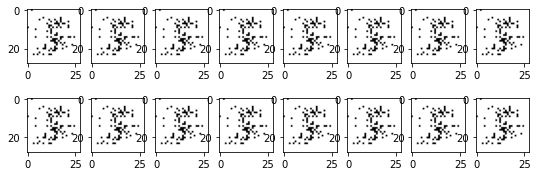

Epoch [17/20], d_loss: 0.0000, g_loss: 17.1485, 


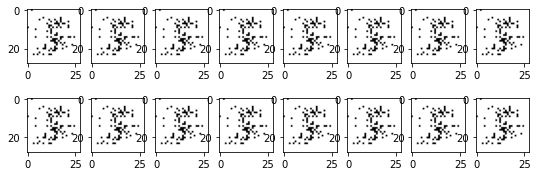

Epoch [18/20], d_loss: 0.0000, g_loss: 16.7967, 


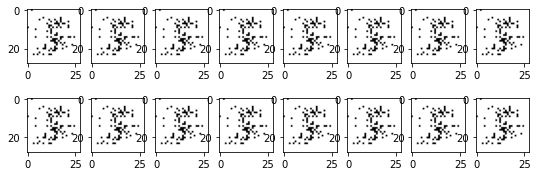

Epoch [19/20], d_loss: 0.0000, g_loss: 16.5162, 


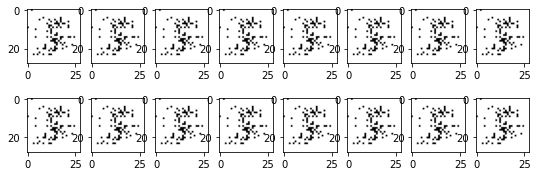

Epoch [20/20], d_loss: 0.0000, g_loss: 16.5045, 


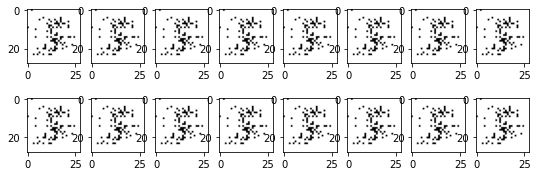

In [48]:
losses = train(G, D, lr=0.002, batch_size=64, num_epochs=20)

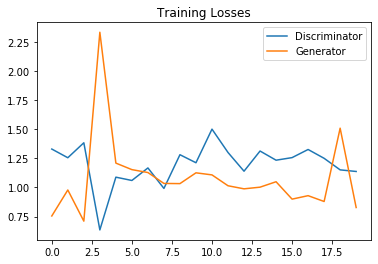

In [0]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

GANs are notoriously difficult to train. One difficulty is that a training curve is no longer
as helpful as it was for a supervised learning problem! The generator and discriminator losses
tend to bounce up and down, since both the generator and discriminator are changing over time.
Tuning hyperparameters is also much more difficult, because we don't have the training curve
to guide us. Newer GAN models like Wasserstein GAN tries to alleviate some of these issues, but
are beyond the scope of this course.

To compound the difficulty of hyperparameter tuning GANs also take a long time to train.
It is tempting to stop training early, but the effects of hyperparameters may not be noticable
until later on in training.

You might have noticed in the images generated by our simple GAN that the model seems to only
output a small number of digit types. This phenomenon is called **mode collapse**. A 
generator can optimize `P(D correctly identifies image generated by G)` by learning
to generate one type of input (e.g. one digit) really well, and not learning how to
generate any other digits at all!

To prevent mode collapse, newer variations of GANs provides the discriminator
with a *small set* of either real or fake data, rather than one at a time. A discriminator
would therefore be able to use the variety of the generated data as a feature to
determine whether the entire small set of data is real or fake.
